Import libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
from metrics import print_evaluation_metrics

Load dataset and prepare df

In [3]:
file_path = "../data/WHO-COVID-19-global-data.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()

Train test split

In [4]:
train = df.iloc[:-30]
test = df.iloc[-30:]

Parameter tuning for order and seasonal order

In [5]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=26493.554, Time=20.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=27445.059, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26984.122, Time=1.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=26538.401, Time=4.01 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=27443.060, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=26508.720, Time=12.39 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=26511.706, Time=13.49 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26497.418, Time=32.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=34.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=26516.485, Time=2.16 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=26487.581, Time=31.02 sec
 ARIMA(2,1,2)(0,0,3)[12] intercept   : AIC=26478.141, Time=67.14 sec
 ARIMA(2,1,2)(1,0,3)[12] intercept   : AIC=26496.671, Time=60.99 sec
 ARIMA(1,1,2)(0,0,3)[12] intercept   : AIC=26493.314, Time=51.03 sec
 ARIMA(2,1,1)(0,0,3)[12] intercept   : AIC=26

/home/samuell/.local/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(5,1,2)(0,0,3)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/samuell/.local/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/samuell/.local/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/samuell/.local/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/home/samuell/.local/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit

 ARIMA(5,1,2)(0,0,3)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(5,1,2)(0,0,3)[12] intercept
Total fit time: 1330.436 seconds


Create Model

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train[target_column], order=best_order, seasonal_order=best_seasonal_order
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00189D+01    |proj g|=  1.23535D+00


 This problem is unconstrained.



At iterate    5    f=  9.36866D+00    |proj g|=  1.44100D-01

At iterate   10    f=  9.35871D+00    |proj g|=  5.69494D-03

At iterate   15    f=  9.35865D+00    |proj g|=  2.05985D-04

At iterate   20    f=  9.35501D+00    |proj g|=  2.40564D-01

At iterate   25    f=  9.27324D+00    |proj g|=  7.52535D-02

At iterate   30    f=  9.24680D+00    |proj g|=  1.22505D-01

At iterate   35    f=  9.24201D+00    |proj g|=  3.37416D-02

At iterate   40    f=  9.23916D+00    |proj g|=  4.54294D-02

At iterate   45    f=  9.23811D+00    |proj g|=  1.44052D-02

At iterate   50    f=  9.23780D+00    |proj g|=  9.73953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                 New_deaths   No. Observations:                 1390
Model:             SARIMAX(5, 1, 2)x(0, 0, [1, 2, 3], 12)   Log Likelihood              -12840.544
Date:                                    Sun, 26 Nov 2023   AIC                          25703.088
Time:                                            15:41:28   BIC                          25760.688
Sample:                                                 0   HQIC                         25724.629
                                                   - 1390                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1462      0.023      6.347      0.000       0.101       0.191
ar.L2         -0.5201      0.023    -22.736      0.000      -0.565      -0.475
ar.L3         -0.4026      0.015    -26.502      0.000      -0.432      -0.373
ar.L4         -0.3318      0.007    -47.122      0.000      -0.346      -0.318
ar.L5         -0.4251      0.013    -33.385      0.000      -0.450      -0.400
ma.L1         -1.1139      0.016    -68.060      0.000      -1.146      -1.082
ma.L2          0.7836      0.009     88.279      0.000       0.766       0.801
ma.S.L12       0.0272      0.035      0.769      0.442      -0.042       0.096
ma.S.L24       0.0304      0.035      0.878      0.380      -0.037       0.098
ma.S.L36      -0.2126      0.007    -28.601      0.000      -0.227      -0.198
sigma2      5.028e+06   2.32e+04    216.617      0.000    4.98e+06    5.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.58   Jarque-Bera (JB):           2843564.46
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                             9.51
Prob(H) (two-sided):                  0.00   Kurtosis:                       223.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

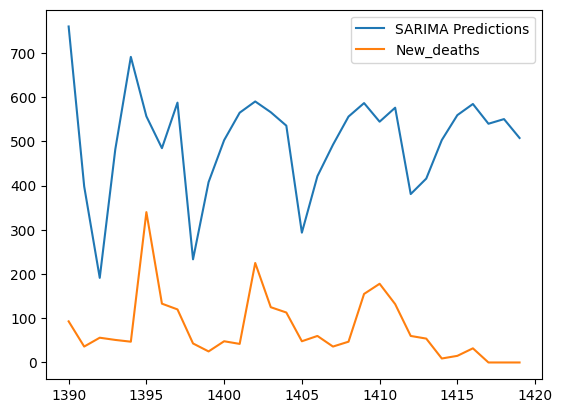

In [7]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels").rename("SARIMA Predictions")
pred.plot(legend=True)
test[target_column].plot(legend=True)

RMSE of the result

In [8]:
print_evaluation_metrics(pred, test[target_column])

Evaluation Metrics:
MSE: 195370.81
RMSE: 442.01
MAE: 424.70
MAPE: inf
SMAPE: 150.10
